# Analysis 2.2
- Outcome: NCGC in 10 years
- Model: Logistic regression
- Risk score: predicted score from logreg model
- Feature selection: Significant variables based on univariate and multivariate analysis
- Drop patients with missing sex 

## Import libraries

In [1]:
%load_ext rpy2.ipython 
# Load the R magic extension

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from scipy.stats import percentileofscore
from helpers.utils import generate_risk_percentile_df, classification_metrics, event_pretty_label, save_to_json

In [3]:
# Add the directory to sys.path
import sys
module_path = Path('./../code')
sys.path.append(str(module_path))
import utils

In [4]:
# Import libraries to allow data to be passed between Python and R env
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import r

pandas2ri.activate()

In [26]:
%%R
source("utils.R")
library(survival)

In [6]:
import warnings
warnings.filterwarnings('ignore', category=pd.errors.DtypeWarning)

# Displays all the columns, does 
pd.set_option('display.max_columns', None)

## Import data

In [42]:
model = 'logreg'
cancer = 'NCGC'
ro.globalenv['model'] = model
ro.globalenv['cancer'] = cancer

analysis_num = '2.2'

In [ ]:
%%R 
r_df_normal <- read.csv("df_analysis0_imputed.csv")


In [43]:
%%R 
outcome_interval <- "_10yr"
outcome <- ifelse(cancer == "ugica", cancer, paste0("ugica_", cancer)) 
outcome_event <- paste0(tolower(cancer), outcome_interval)
model_filename <- paste0(model, "_", outcome_event, ".rds")

In [ ]:
univariate_filename = f'./../results/univariate_analysis_{analysis_num}_{cancer}.csv'
multivariate_filename = f'./../results/multivariate_analysis_{analysis_num}_{cancer}.csv'
risk_results_filename = f'./../results/risk_results_analysis_{analysis_num}_{cancer}.csv'
outcome_event = r['outcome_event'][0]
outcome_interval = r['outcome_interval'][0]

In [ ]:
# Pass the DataFrame into the R environment
def pass_df(df, r_df_name):
    ro.globalenv[r_df_name] = df

ro.globalenv['numerical_vars'] = utils.NUMERICAL_VARS
ro.globalenv['categorical_vars'] = utils.CATEGORICAL_VARS 
ro.globalenv['univariate_filename'] = str(univariate_filename)
ro.globalenv['multivariate_filename'] = str(multivariate_filename)

## Univariate analysis - logistic regression

### Factorize categorical vars and set reference levels

In [11]:
%%R
# Remove categorical variables that we do not want to do univariate analysis on
vars_categorical_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore &
    names(r_df_normal) %in% categorical_vars
]

# Factorize 
for (i in vars_categorical_for_univariate) {
    r_df_normal[[i]] <- factor(r_df_normal[[i]])
}

# Set reference levels 
r_df_normal$race_clean <- relevel(r_df_normal$race_clean, ref = 'White')
r_df_normal$ethnicity <- relevel(r_df_normal$ethnicity, ref='Not Hispanic or Latino')
r_df_normal$alcohol_binary <- relevel(r_df_normal$alcohol_binary, ref = '0')
r_df_normal$tobacco_binary <- relevel(r_df_normal$tobacco_binary, ref = '0')
r_df_normal$hpylori_active_chronic_binary <- relevel(r_df_normal$hpylori_active_chronic_binary, ref = '0')

In [12]:
%%R
vars_for_univariate <- names(r_df_normal)[
    !names(r_df_normal) %in% cols_to_ignore
]
vars_for_univariate

 [1] "sex_missing"                   "race_clean"                   
 [3] "ethnicity"                     "alcohol_binary"               
 [5] "tobacco_binary"                "hpylori_active_chronic_binary"
 [7] "hnca"                          "achalasia"                    


 [9] "pud"                           "gerd"                         
[11] "cad"                           "famhx_cancer"                 
[13] "famhx_esophagealca"            "famhx_gastricca"              
[15] "famhx_colonca"                 "famhx_barretts"               
[17] "ASA"                           "PPI"                          
[19] "NSAID"                         "age"                          
[21] "BMI_baseline_all"             


In [13]:
%%R
# HRs, 95% CIs, p-values
results_list <- list()

for (var in vars_for_univariate) {
    # Skip if fewer than 2 levels, ie. 100% in one group
    if (length(unique(na.omit(r_df_normal[[var]]))) < 2) next

    # Build formula
    model <- train_logreg_model(train_set = r_df_normal, selected_vars = var, outcome = outcome_event)

    # Get model summary in formatted dataframe 
    model_df <- get_logreg_univariate_summary(model, var, categorical_vars)
    results_list[[var]] <- model_df
}

final_results <- do.call(rbind, results_list)
write.csv(final_results, univariate_filename)

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to console]: Waiting for profiling to be done...

R[write to con

In [14]:
# Print the list of significant variables based on univariate analysis
df_univariate = pd.read_csv(univariate_filename)

In [15]:
df_univariate[df_univariate.p_value < 0.05]

,Unnamed: 0,Variable,Level,OR,CI_lower,CI_upper,p_value
0,sex_missing.(Intercept),sex_missing,(Intercept),0.000046,0.000034,0.000061,0.000000e+00
1,sex_missing.sex_missingMALE,sex_missing,MALE,1.883531,1.294319,2.772793,1.083235e-03
2,race_clean.(Intercept),race_clean,(Intercept),0.000048,0.000033,0.000066,0.000000e+00
3,race_clean.race_cleanAsian,race_clean,Asian,3.510123,1.843795,6.391640,6.547839e-05
4,race_clean.race_cleanBlack or African American,race_clean,Black or African American,2.583438,1.523335,4.346331,3.582283e-04
7,ethnicity.(Intercept),ethnicity,(Intercept),0.000079,0.000062,0.000099,0.000000e+00
8,ethnicity.ethnicityHispanic or Latino,ethnicity,Hispanic or Latino,2.048418,1.350732,3.049875,5.331289e-04
9,ethnicity.ethnicityNo matching concept,ethnicity,No matching concept,0.158006,0.070064,0.308637,7.517299e-07
10,alcohol_binary.(Intercept),alcohol_binary,(Intercept),0.000067,0.000054,0.000081,0.000000e+00
12,tobacco_binary.(Intercept),tobacco_binary,(Intercept),0.000058,0.000046,0.000071,0.000000e+00


## Feature selection

In [16]:
%%R 
selected_vars <- final_results %>%
    filter(Level != "(Intercept)") %>%
    filter(p_value < 0.05) %>%
    distinct(Variable) %>%
    pull(Variable)
selected_vars

selected_vars <- selected_vars[
    !selected_vars %in% cols_to_ignore]
selected_vars

 [1] "sex_missing"     "race_clean"      "ethnicity"       "tobacco_binary" 
 [5] "hnca"            "pud"             "gerd"            "cad"            
 [9] "famhx_cancer"    "famhx_gastricca" "ASA"             "PPI"            
[13] "NSAID"           "age"            


### Forest plot for univariate visualization

In [17]:
%%R 
forestplot_df <- final_results[(final_results$Variable %in% selected_vars) & (final_results$Level != '(Intercept)'), ]
forestplot_df$Variable_full <- rownames(forestplot_df)

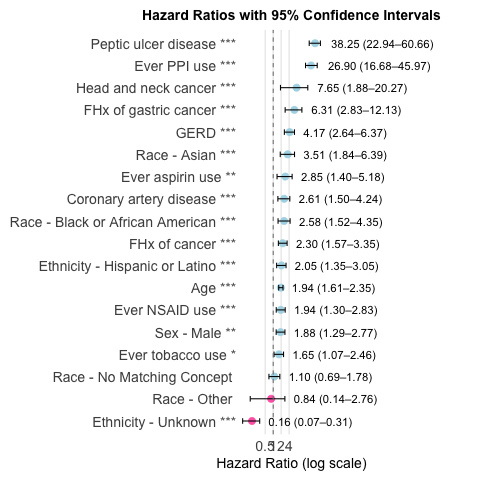

In [18]:
%%R 
plot_univariate_forest(forestplot_df)

## Logistic regression multivariate model training

#### Split dataset into training and validation

In [19]:
%%R 
# Partition data
splits <- partition_data(r_df_normal, selected_vars, outcome_event, p=0.8)
train_set <- splits$train_set
validation_set <- splits$validation_set

# Train model
logreg_model <- train_logreg_model(train_set, selected_vars, outcome_event, model_func=glm)

[1] "Dataset Controls 34070" "Dataset Cases 113"     
[1] "Training Controls 27253" "Training Cases 94"      
[1] "Validation Controls 6817" "Validation Cases 19"     



#### Multivariate analysis

In [20]:
%%R 
# Saves hazard ratio from multivariate analysis into file
multivariate_df <- save_multivariate_logreg_results(logreg_model, multivariate_filename)

Multivariate results saved to ./../results/multivariate_analysis_2.2_NCGC.csv 


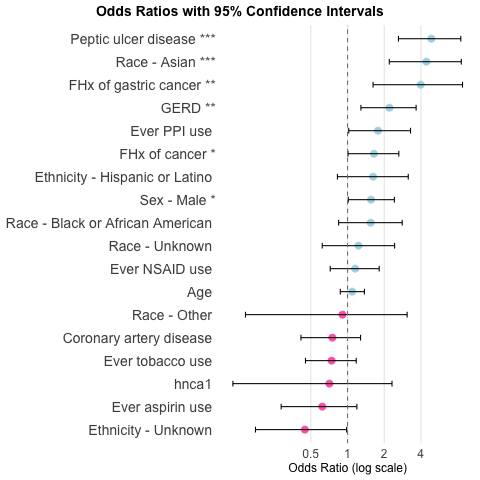

In [21]:
%%R 
plot_multivariate_forest(multivariate_df)

## Results

### Predict events

In [27]:
%%R 
# Get the outcomes in 1 year, 3 year and 5 year horizons
r_df_validation_risk <- generate_event_dataframe(validation_set)
event_5_years <- r_df_validation_risk[[outcome_event]]

# Get the predicted risk 
risk_5_years <- calculate_risk_from_logreg(logreg_model, validation_set)
r_df_validation_risk$pred_risk <- risk_5_years

In [28]:
%%R 
# Convert variable from int to character before transfer to python
r_df_validation_risk[['race']] <- as.character(r_df_validation_risk[['race']])
r_df_validation_risk[['sex']] <- as.character(r_df_validation_risk[['sex']])
r_df_validation_risk[['age_bucket']] <- as.character(r_df_validation_risk[['age_bucket']])
r_df_validation_risk[['visit_year_bucket']] <- as.character(r_df_validation_risk[['visit_year_bucket']])


In [29]:
%%R 
# Set risk threshold to calculate sensitivity and specificity
percentile = 70
cat("\nSensitivity and Metrics at 70% Specificity")
threshold <- quantile(risk_5_years, probs = percentile / 100)
calculate_cm_by_percentile(risk_5_years, event_5_years, threshold)


Sensitivity and Metrics at 70% Specificity

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.814 
Sensitivity: 0.7894737 
Specificity: 0.7013349 
PPV: 0.007313506 
NPV: 0.9991641 
NNS: 154.3791 
     predicted_class
event    0    1
    0 4781 2036
    1    4   15


### Sensitivity and Metrics at threshold that maximizes Youdens

In [30]:
%%R
# Find the threshold that maximizes Youden's J (sensitivity + specificity - 1)
roc_obj <- roc(response = event_5_years, predictor = risk_5_years)
optimal_threshold <- coords(
  roc_obj,
  x = "best",
  best.method = "youden",
  transpose = FALSE
)$threshold

cat("\nSensitivity and Metrics at Threshold set by Youden index")
calculate_cm_by_percentile(risk_5_years, event_5_years, optimal_threshold)

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases




Sensitivity and Metrics at Threshold set by Youden index

R[write to console]: Setting levels: control = 0, case = 1

R[write to console]: Setting direction: controls < cases



C-statistic (AUROC): 0.814 
Sensitivity: 0.7368421 
Specificity: 0.8274901 
PPV: 0.01176471 
NPV: 0.9991144 
NNS: 91.91917 
     predicted_class
event    0    1
    0 5641 1176
    1    5   14


### AUROC curves and PR curve

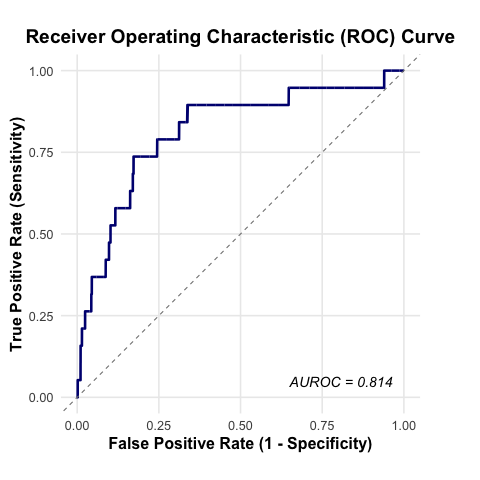

In [31]:
%%R 
# Generate all plots
p1 <- plot_roc_gg(event_5_years, risk_5_years)
p2 <- plot_pr_gg(event_5_years, risk_5_years)
p1

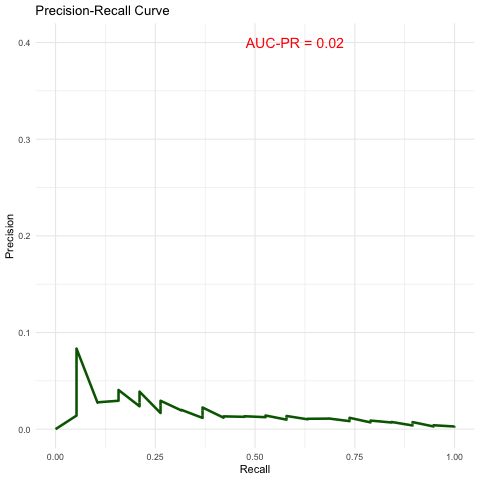

In [32]:
%%R 
p2

### Metrics for each percentile, subdivided by cancer subtype

#### Analysis

In [33]:
r_df_validation_risk = r['r_df_validation_risk']  
df_validation_risk = pandas2ri.rpy2py(r_df_validation_risk)
pred_risk = 'pred_risk'
optimal_threshold = r['optimal_threshold'][0]
optimal_threshold_percentile = percentileofscore(df_validation_risk[pred_risk], optimal_threshold, kind='weak')/100.
percentile_cutoffs = [0, 0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.975, 0.99, 1, optimal_threshold_percentile]

#Create different risk percentiles
df_validation_risk_percentile = generate_risk_percentile_df(df_validation_risk, pred_risk, percentile_cutoffs, optimal_threshold)

In [34]:
df_validation_risk.head()

,time,event_ugica,event_escc,event_eac,event_cgc,event_ncgc,race,sex,age_bucket,visit_year_bucket,ugica_5yr,escc_5yr,eac_5yr,cgc_5yr,ncgc_5yr,ugica_1yr,escc_1yr,eac_1yr,cgc_1yr,ncgc_1yr,ugica_3yr,escc_3yr,eac_3yr,cgc_3yr,ncgc_3yr,ugica_10yr,escc_10yr,eac_10yr,cgc_10yr,ncgc_10yr,pred_risk,actual_percentile,risk_group,risk_p0.5,risk_p0.6,risk_p0.7,risk_p0.75,risk_p0.8,risk_p0.8259215915740199,risk_p0.85,risk_p0.9,risk_p0.95,risk_p0.975,risk_p0.99,risk_p1,high_risk,high_risk_youden
1,59.071869,0,0,0,0,0,No matching concept,MALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001914,0.438414,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.993840,0,0,0,0,0,No matching concept,FEMALE,60-69,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002153,0.499269,0.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,66.726899,0,0,0,0,0,White,MALE,40-49,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002816,0.638678,0.60,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,157.043121,0,0,0,0,0,No matching concept,FEMALE,80-85,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002803,0.634289,0.60,1,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0.164271,0,0,0,0,0,White,MALE,70-79,2011-2014,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003594,0.751463,0.75,1,1,1,1,0,0,0,0,0,0,0,0,0,0


In [35]:
risk_groups = [f"risk_p{percentile_cutoffs[i+1]}" for i in range(len(percentile_cutoffs) - 1)]
events = [f'ugica{outcome_interval}', f'escc{outcome_interval}', f'eac{outcome_interval}', f'cgc{outcome_interval}', f'ncgc{outcome_interval}']
race_groups = df_validation_risk.race.unique()
age_groups = df_validation_risk.age_bucket.unique()
sex_groups = df_validation_risk.sex.unique()
visit_year_groups = df_validation_risk.visit_year_bucket.unique()

results_dataframe = []

# Get summary statistics for each risk percentile 
for risk_group in risk_groups:
    for event in events: 
        row = classification_metrics(df_validation_risk, risk_group, event)
        results_dataframe.append(row)

# Get summary statistics for each race 
for race in race_groups:
    df_risk_race = df_validation_risk[df_validation_risk.race == race]

    row = classification_metrics(df_risk_race, "high_risk_youden", outcome_event, race)
    results_dataframe.append(row)

# Get summary statistics for each sex 
for sex in sex_groups:
    df_risk_sex = df_validation_risk[df_validation_risk.sex == sex]

    row = classification_metrics(df_risk_sex, "high_risk_youden", outcome_event, sex)
    results_dataframe.append(row)

# Get summary statistics for each age
for age_bucket in age_groups:
    df_risk_age = df_validation_risk[df_validation_risk.age_bucket == age_bucket]

    row = classification_metrics(df_risk_age, "high_risk_youden", outcome_event, age_bucket)
    results_dataframe.append(row)

# Get summary statistics for visit year ranges
for visit_year_bucket in visit_year_groups:
    df_risk_visit_year = df_validation_risk[df_validation_risk.visit_year_bucket == visit_year_bucket]

    row = classification_metrics(df_risk_visit_year, "high_risk_youden", outcome_event, visit_year_bucket)
    results_dataframe.append(row)

df_results = pd.DataFrame(results_dataframe)

/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: RuntimeWarning: invalid value encountered in scalar divide
  prevalence_in_risk_group = round((total_cases_in_risk_group / total_in_risk_group) * 100, 1)
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:71: RuntimeWarning: invalid value encountered in scalar divide
  ser = tp / (tp + fp) # screened event rate is the number of cases found / those screened
/Users/alyssa.chen/Library/CloudStorage/OneDrive-TheMountSinaiHospital/Research/UGIRisk/Analysis/ugi-risk/notebook/helpers/utils.py:77: Ru

#### Metrics for each percentile and cancer subtype, ordered by percentile

In [36]:
df_results.tail()

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
70,high_risk_youden,youden,ncgc_10yr,70-79,1955,5,355,1 (0.3%),0.3,1,354,4,1601,0.817347,0.182653,20.000000,81.892583,0.281690,99.750779,3079.864865,0.018926
71,high_risk_youden,youden,ncgc_10yr,50-59,1266,5,225,4 (1.8%),1.8,4,221,1,1045,0.825334,0.174666,80.000000,82.543444,1.777778,99.904398,59.446830,0.625434
72,high_risk_youden,youden,ncgc_10yr,2011-2014,2859,9,486,8 (1.6%),1.6,8,478,1,2381,0.832985,0.167015,88.888889,83.280867,1.646091,99.958018,62.339903,0.721698
73,high_risk_youden,youden,ncgc_10yr,2015-2018,2291,9,450,6 (1.3%),1.3,6,444,3,1847,0.805652,0.194348,66.666667,80.619817,1.333333,99.837838,85.384615,0.472865
74,high_risk_youden,youden,ncgc_10yr,2019-2022,1667,1,254,0 (0.0%),0.0,0,254,1,1413,0.847122,0.152878,0.000000,84.763047,0.000000,99.929279,-1414.000000,-0.152370


#### Metrics for each percentile and cancer subtype, ordered by cancer subtype

In [37]:
df_results.sort_values(by=['event', 'risk_group'])

,risk_group,risk_percentile,event,strata,actual controls,actual cases,total pts in risk group,cancer prevalence in risk group,prevalence,tp,fp,fn,tn,pred correct,pred incorrect,sensitivity,specificity,ppv,npv,nns,youden_index
3,risk_p0.5,0.5,cgc_10yr,all,6822,14,3418,12 (0.4%),0.4,12,3406,2,3416,0.501463,0.498537,85.714286,50.073292,0.351083,99.941486,341.800000,0.357876
8,risk_p0.6,0.6,cgc_10yr,all,6822,14,2734,11 (0.4%),0.4,11,2723,3,4099,0.601229,0.398771,78.571429,60.085019,0.402341,99.926865,303.761322,0.386564
13,risk_p0.7,0.7,cgc_10yr,all,6822,14,2051,10 (0.5%),0.5,10,2041,4,4781,0.700848,0.299152,71.428571,70.082087,0.487567,99.916405,247.541618,0.415107
18,risk_p0.75,0.75,cgc_10yr,all,6822,14,1709,10 (0.6%),0.6,10,1699,4,5123,0.750878,0.249122,71.428571,75.095280,0.585138,99.921982,197.192308,0.465239
23,risk_p0.8,0.8,cgc_10yr,all,6822,14,1367,8 (0.6%),0.6,8,1359,6,5463,0.800322,0.199678,57.142857,80.079156,0.585223,99.890291,210.298819,0.372220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,risk_p0.9,0.9,ugica_10yr,all,6775,61,684,21 (3.1%),3.1,21,663,40,6112,0.897162,0.102838,34.426230,90.214022,3.070175,99.349805,41.322649,0.246403
35,risk_p0.95,0.95,ugica_10yr,all,6775,61,341,13 (3.8%),3.8,13,328,48,6447,0.944997,0.055003,21.311475,95.158672,3.812317,99.260970,32.538455,0.164701
40,risk_p0.975,0.975,ugica_10yr,all,6775,61,171,8 (4.7%),4.7,8,163,53,6612,0.968403,0.031597,13.114754,97.594096,4.678363,99.204801,25.752197,0.107089
45,risk_p0.99,0.99,ugica_10yr,all,6775,61,69,3 (4.3%),4.3,3,66,58,6709,0.981861,0.018139,4.918033,99.025830,4.347826,99.142899,28.647340,0.039439


In [38]:
df_results.to_csv(risk_results_filename)

### Save model, threshold and validation set

In [44]:
%%R 
# Save model
saveRDS(logreg_model, model_filename)

In [40]:
selected_vars = list(r['selected_vars'])  

model_variables = {
    outcome_event: {
        "threshold": optimal_threshold,
        "variables": selected_vars
    }
}

# Save
save_to_json(model_variables, "thresholds.json", key=model)

Saved to thresholds.json
